# Training and Fine-Tuning BERT for Classification
## Classfying newspaper articles by topic

This notebook will demonstrate how users can train and fine-tune a BERT model for classification with the popular HuggingFace `transformers` Python library.

We will fine-tune a BERT model on news topics discussed [here](https://www.tandfonline.com/doi/full/10.1080/21670811.2020.1767509) with the goal of predicting the topic of a news article. The genres include:

-   'business'
-   'entertainment'
-   'politics'
-   'other'

Please download the data from the [bdaca github](https://github.com/uvacw/teaching-bdaca/tree/main/modules/machinelearning-text-exercises)

**Basic steps involved in using BERT and HuggingFace:**
- Split your dataset into training, validation, and testing subsets.
- Convert your data into a format that BERT can process.
- Create dataset objects by joining your data and labels.
- Load the pre-trained BERT model.
- Refine the model by training it on your training data.
- Use the model to make predictions and assess its performance on your test data.


_This notebook is heavily inspired by Herties BERT for humanities tutorial_

<br><br>

## **Import necessary Python libraries and modules**

In [1]:
!pip3 install transformers

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


Next, we will import necessary Python libraries and modules. 

In [106]:
import gzip
import json
import pickle
import random
import sys
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import ticker
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import torch
from transformers import Trainer, TrainingArguments
from sklearn.metrics import f1_score

from collections import defaultdict

sns.set(style='ticks', font_scale=1.2)
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils import compute_sample_weight

<br><br>

## **Read in data, and split into Train-Val-Test (60-20-20) samples**


This will read in the annotated newspaper data from Vermeer et al., and split it into train, val and test samples. 


In [6]:

csv.field_size_limit(sys.maxsize)

def get_labeled_data(fn='labeled.csv'):
    text= []
    label= []

    with open(fn) as fi:
        next(fi)
        reader = csv.reader(fi, delimiter=',')
        for row in reader:
            try:
                text.append(row[0])
                label.append(row[1])
            except:
                # invalid row, probably an empty one. let's just ignore
                pass
    return text, label

texts, labels = get_labeled_data()


# Split your data into training and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [7]:
print(f"We have {len(X_train)} train examples, {len(X_val)} validation examples, and {len(X_test)} test examples.")

We have 1672 train examples, 558 validation examples, and 558 test examples.


In [105]:
#We will be using a Dutch model, as our data is Dutch-- specifically the '"GroNLP/bert-base-dutch-cased"' model. Check out Hugging Face's documentation for more information on the different BERT models.
model_name = 'bert-base-dutch-cased'

# We'll run our code on NVIDIA GPUs using the program management system.
device_name = 'cuda'

# We set the maximum number of tokens in each document to be 512, which is the maximum length for BERT models.
max_length = 512

# We define the directory where we'll save our trained model. You can choose any name for the directory.
save_directory = 'my_trained_model'

Here's an example of a training text and training label:

In [9]:
X_train[0], y_train[0]

('Bij een steekpartij op de Admiraal Helfrichstraat, vlakbij het Mercatorplein, is rond 23.45 uur een man zwaargewond geraakt.  Dat gebeurde vlak nadat het Mercatorplein, waar Marokkaanse voetbalsupporters zich ophielden, was leeggelopen vanwege de regen. Agenten die net aan het inpakken waren renden daarna naar de Admiraal Helfrichstraat.  Meerdere ambulances en een mobiel medisch traumateam werden opgeroepen voor het slachtoffer. Hij is met spoed per ambulance naar het ziekenhuis overgebracht. Volgens getuigen was de man er ernstig aan toe.  PeppersprayDe agenten konden iets verdererop, op een fietspad tussen de Admiraal Helfrichstraat en de Jan Evertsenstraat, de vermoedelijke dader aanhouden. Bij de aanhouding moesten ze pepperspray gebruiken.  Het vermoedelijke wapen wat bij de steekpartij gebruikt is lag vlakbij de dader. Waarschijnlijk was het slachtoffer een fietser, want vlakbij de man werd een fiets gevonden.  Wij maken gebruik van functionele en analytische cookies om inzich

<br><br>

## **Implementing a Baseline Model using Logistic Regression**

In this step, we train and evaluate a basic TF-IDF baseline model with logistic regression. Despite using a very small dataset, we observe a performance that is better than random. We will now check if BERT can outperform this strong baseline!

In [10]:
vectorizer = TfidfVectorizer()
Xtrain = vectorizer.fit_transform(X_train)
Xtest = vectorizer.transform(X_test)

We train a logistic regression model from scikit-learn on the newspaper training data, and then we use the trained model to make predictions on our test set.

In [11]:
model = LogisticRegression(max_iter=1000).fit(Xtrain, y_train)
predictions = model.predict(Xtest)

We can leverage the `classification_report` function provided by scikit-learn to assess the performance of the logistic regression model in terms of its ability to predict newspaper topics that match the actual labels.

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

               precision    recall  f1-score   support

     business       0.77      0.43      0.55        94
entertainment       0.74      0.98      0.84       318
        other       0.94      0.28      0.43        58
     politics       0.88      0.68      0.77        88

     accuracy                           0.77       558
    macro avg       0.83      0.59      0.65       558
 weighted avg       0.79      0.77      0.74       558



What do you think of this model? Not too bad for a baseline model, right? Lets see whether we can improve this using BERT.

## Encode data for BERT

To prepare our data for use with BERT, we need to encode the texts and labels in a way that the model can understand. Here are the steps we'll follow:

1. Convert the labels from strings to integers.

2. Tokenize the texts, which involves breaking them up into individual words, and then convert the words into "word pieces" that can be matched with their corresponding embedding vectors.

3. Truncate texts that are longer than 512 tokens, or pad texts that are shorter than 512 tokens with a special padding token.

4. Add special tokens to the beginning and end of each document, including a start token, a separator between sentences, and a padding token as necessary.


We will be using the `AutoTokenizer.from_pretrained()` module from HuggingFace library to encode our texts. This module will handle all the encoding for us, including breaking word tokens into word pieces, truncating to 512 tokens, and adding padding and special BERT tokens.

In [33]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base")

Downloading:   0%|          | 0.00/254 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In this section, we will generate a mapping of our news topics to integer keys. We begin by extracting the unique labels from our dataset and create a dictionary that associates each label with an integer.

In [70]:
unique_labels = set(label for label in y_train)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [71]:
label2id.keys()

dict_keys(['other', 'politics', 'business', 'entertainment'])

In [72]:
id2label.keys()

dict_keys([0, 1, 2, 3])

Now let's encode our texts and labels!

In [73]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(X_test, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in y_train]
val_labels_encoded = [label2id[y] for y in y_val]
test_labels_encoded  = [label2id[y] for y in y_test]

**Examine a news article in the training set after encoding**

In [74]:
' '.join(train_encodings[0].tokens[0:100])

'[CLS] Bij een steekpartij op de Admiraal Hel ##fri ##ch ##straat , vlakbij het Merc ##ator ##plein , is rond 23 . 45 uur een man zwaargewond geraakt . Dat gebeurde vlak nadat het Merc ##ator ##plein , waar Marokkaans ##e voetbal ##supporters zich ophield ##en , was leeg ##gelopen vanwege de regen . Agenten die net aan het in ##pakken waren renden daarna naar de Admiraal Hel ##fri ##ch ##straat . Meerdere ambulance ##s en een mobiel medisch trauma ##team werden opgeroepen voor het slachtoffer . Hij is met spoed per ambulance naar het ziekenhuis overgebracht . Volgens getuigen'

**Examine a news article in test set after encoding**

In [75]:
' '.join(test_encodings[0].tokens[0:100])

'[CLS] Een 41 - jarige man is veroordeeld wegens mishandeling in een café , waarbij hij zonder aanleiding een andere man met een bier ##glas in zijn gezicht stak . De rechter heeft tbs en een geldboete van ruim 3 . 900 euro opgelegd . Het incident gebeurde op 25 februari 2017 in een café in Amsterdam . Het slachtoffer werd belaagd toen hij naar de bar wilde lopen om drank te bestelle ##n . Volgens getuigen was er geen enkele aanleiding voor de aanvaring . Het slachtoffer , destijds nog een student , liep meerdere blijven ##de litteken ##s'

**Examine the training labels after encoding**

In [76]:
set(train_labels_encoded)

{0, 1, 2, 3}

**Examine the test labels after encoding**

In [77]:
set(test_labels_encoded)

{0, 1, 2, 3}

<br><br>

## **Create a custom Torch dataset by following these steps:**

Here we combine the encoded labels and texts into dataset objects. We use the custom Torch `MyDataSet` class to make a `train_dataset` object from  the `train_encodings` and `train_labels_encoded`. We also make a `val_dataset`, `test_dataset` object from `test_encodings` and `val_encodings`, and `val_labels_encoded` and `test_labels_encoded`.


In [78]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [79]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
val_dataset = MyDataset(val_encodings, val_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

**Examine a news article in the Torch `training_dataset` after encoding**

In [80]:
' '.join(train_dataset.encodings[0].tokens[0:100])

'[CLS] Bij een steekpartij op de Admiraal Hel ##fri ##ch ##straat , vlakbij het Merc ##ator ##plein , is rond 23 . 45 uur een man zwaargewond geraakt . Dat gebeurde vlak nadat het Merc ##ator ##plein , waar Marokkaans ##e voetbal ##supporters zich ophield ##en , was leeg ##gelopen vanwege de regen . Agenten die net aan het in ##pakken waren renden daarna naar de Admiraal Hel ##fri ##ch ##straat . Meerdere ambulance ##s en een mobiel medisch trauma ##team werden opgeroepen voor het slachtoffer . Hij is met spoed per ambulance naar het ziekenhuis overgebracht . Volgens getuigen'

**Examine a news article in the Torch `test_dataset` after encoding**

In [81]:
' '.join(test_dataset.encodings[1].tokens[0:100])

'[CLS] Fiets ##ers en voetgangers kunnen de Maas ##tunnel gewoon blijven gebruiken Veel automobilisten stonden maandagochtend voor een verrassing in Rotterdam - Zuid , de Maas ##tunnel is ook van Zuid naar Noord dicht . Op Zuid waren er onder andere op de Bri ##els ##ela ##an richting de Erasmus ##brug verkeers ##op ##stop ##ping ##en . Af ##gelopen weekend waren beide tunnel ##buizen gesloten voor een veiligheids ##oefening . Daarna is begonnen met het verwijderen van asfalt in de werk ##buis van Noord naar Zuid . Omdat die werkzaam ##heden veel stof veroorzaken , is ook de tunnel ##buis'

In [82]:
len(id2label)

4

<br><br>

## **Initialize the pre-trained BERT model**

We load a pre-trained Dutch BERT model and transfer it to CUDA for efficient computation.

**Note**: If you intend to repeat the fine-tuning process after previously executing the subsequent cells, ensure that you re-run this cell to reload the original pre-trained model before commencing the fine-tuning again.

In [99]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

loading configuration file https://huggingface.co/GroNLP/bert-base-dutch-cased/resolve/main/config.json from cache at /home/akroon/.cache/huggingface/transformers/443c1d513d458927e5883e0b1298cdb70ba4d14a55faa236d93e0598efc78fc7.3b16931b59b9aafc3e068b6cd5f0be5e02a209a299e39b1e0056d89eaa3b6a7b
Model config BertConfig {
  "_name_or_path": "GroNLP/bert-base-dutch-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_toke

<br><br>

## **Configure the parameters required for fine-tuning BERT**

The following parameters are crucial for fine-tuning BERT and will be specified in the HuggingFace TrainingArguments objects that we will subsequently pass to the HuggingFace Trainer object. While there are numerous other arguments, we'll focus on the fundamental ones and some common pitfalls.

When fine-tuning your own model, it's critical to experiment with these parameters to identify the optimal configuration for your specific dataset.

| Parameter                     | Explanation                                                                                                                          |
|-------------------------------|--------------------------------------------------------------------------------------------------------------------------------------|
| `num_train_epochs`            | The total number of training epochs. This refers to how many times the entire dataset will be processed. Too many epochs can lead to overfitting.|
| `per_device_train_batch_size` | The batch size per device during training.                                                                                           |
| `per_device_eval_batch_size`  | The batch size for evaluation.                                                                                                      |
| `warmup_steps`                | The number of warmup steps for the learning rate scheduler. A smaller value is recommended for small datasets.                         |
| `weight_decay`                | The strength of weight decay, which reduces the size of weights, similar to regularization.                                          |
| `output_dir`                  | The directory where the fine-tuned model and configuration files will be saved.                                                     |
| `logging_dir`                 | The directory where logs will be stored.                                                                                            |
| `logging_steps`               | How often to print logging output. This enables us to terminate training early if the loss is not decreasing.                        |
| `evaluation_strategy`         | Evaluates while training so that we can monitor accuracy improvements.                                                              |


<br><br>

## **Fine-tune the BERT model**

Initially, we define a custom evaluation function that returns the accuracy of the model. However, this function can be modified to return other metrics such as precision, recall, F1 score, or any other desired evaluation metric.

In [116]:
def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro', sample_weight=compute_sample_weight('balanced', labels))
    return {'accuracy': acc, 'macro_f1': macro_f1}

Then we create a HuggingFace `Trainer` object using the `TrainingArguments` object that we created above. We also send our `compute_metrics` function to the `Trainer` object, along with our test and train datasets.


## **optimize your model based on a metric you select**

In [117]:
metric_name = 'macro_f1' # you can chance this for `accuracy` etc, according to the function `compute_metrics`

In [118]:
# Instantiate an object of the TrainingArguments class with the following parameters:
training_args = TrainingArguments(
    
    # Number of training epochs
    num_train_epochs=5,
    
    # Batch size for training
    per_device_train_batch_size=8,
    
    # Batch size for evaluation
    per_device_eval_batch_size=8,
    
    # Learning rate for optimization
    learning_rate=5e-5,
    
    # Load the best model at the end of training
    load_best_model_at_end=True,
    
    # Metric used for selecting the best model
    metric_for_best_model=metric_name,
    
    # Number of warmup steps for the optimizer
    warmup_steps=0,
    
    # L2 regularization weight decay
    weight_decay=0.01,
    
    # Directory to save the fine-tuned model and configuration files
    output_dir='./results',
    
    # Directory to store logs
    logging_dir='./logs',
    
    # Log results every n steps
    logging_steps=20,
    
    # Strategy for evaluating the model during training
    evaluation_strategy='steps',
)

using `logging_steps` to initialize `eval_steps` to 20
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [119]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,           # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics      # our custom evaluation function 
)

Time to finally fine-tune! 

Be patient; if you've set everything in Colab to use GPUs, then it should only take a minute or two to run, but if you're running on CPU, it can take hours.

After every 20 steps (as we specified in the TrainingArguments object), the trainer will output the current state of the model, including the training loss, validation loss, and accuracy (from our `compute_metrics` function).

You should see the loss going down and the accuracy going up. If instead they are staying the same or oscillating, you probably need to change the fine-tuning parameters.

In [120]:
trainer.train()

/home/akroon/.local/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1672
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 525
/home/akroon/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,Macro F1
20,0.017300,1.055703,0.797491,0.641052
40,0.008000,1.279359,0.750896,0.710196
60,0.503300,1.012222,0.781362,0.767752
80,0.350600,0.637358,0.817204,0.789877
100,0.450300,0.540615,0.822581,0.704219
120,0.248500,0.535908,0.840502,0.756438
140,0.106700,0.714249,0.831541,0.769418
160,0.100500,0.734517,0.829749,0.739374
180,0.157600,0.757192,0.842294,0.752635
200,0.084800,0.750570,0.849462,0.789495


***** Running Evaluation *****
  Num examples = 558
  Batch size = 8
/home/akroon/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 558
  Batch size = 8
/home/akroon/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 558
  Batch size = 8
/home/akroon/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.wa

TrainOutput(global_step=525, training_loss=0.09263653684230078, metrics={'train_runtime': 349.3344, 'train_samples_per_second': 23.931, 'train_steps_per_second': 1.503, 'total_flos': 2199647921602560.0, 'train_loss': 0.09263653684230078, 'epoch': 5.0})

<br><br>

## **Save fine-tuned model**

The following cell will save the model and its configuration files to a directory in Colab. To preserve this model for future use, you should download the model to your computer.

In [ ]:
trainer.save_model(save_directory)

(Optional) If you've already fine-tuned and saved the model, you can reload it using the following line. You don't have to run fine-tuning every time you want to evaluate.

In [ ]:
# trainer = AutoModelForSequenceClassification.from_pretrained(save_directory)

<br><br>

## **Evaluate fine-tuned model on the validation set**

The following function of the `Trainer` object will run the built-in evaluation, including our `compute_metrics` function.

In [122]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 558
  Batch size = 8


{'eval_loss': 0.8450928330421448,
 'eval_accuracy': 0.8548387096774194,
 'eval_macro_f1': 0.8065122187122633,
 'eval_runtime': 5.0814,
 'eval_samples_per_second': 109.813,
 'eval_steps_per_second': 6.888,
 'epoch': 5.0}

<br><br>

## **Evaluate fine-tuned model on the test set**

We may desire a more detailed evaluation of the model, hence we extract the predicted labels.

In [124]:
predicted_results = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 558
  Batch size = 8
/home/akroon/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [125]:
predicted_results.predictions.shape

(558, 4)

In [126]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [127]:
len(predicted_labels)

558

In [129]:
print(classification_report(y_test, 
                            predicted_labels))

               precision    recall  f1-score   support

     business       0.84      0.81      0.83        94
entertainment       0.92      0.95      0.93       318
        other       0.85      0.76      0.80        58
     politics       0.87      0.86      0.87        88

     accuracy                           0.89       558
    macro avg       0.87      0.85      0.86       558
 weighted avg       0.89      0.89      0.89       558



<br><br>

## **Extracting Correct and Incorrect Classifications for Analysis**

Now that we have obtained the predicted labels, let's perform some analysis.

The fine-tuning and extraction of predicted labels using BERT is now complete. You can use the predicted labels just like you would with any other classification model. Here are some examples.

To start, let's print out some example predictions that were correct.

In [132]:
for _true_label, _predicted_label, _text in random.sample(list(zip(y_test, predicted_labels, X_test)), 20):
  if _true_label == _predicted_label:
    print('LABEL:', _true_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

LABEL: entertainment
REVIEW TEXT: Update & VideoBREDA - ,,Niet te begrijpen, diep triest. Breda is altijd mijn veilige stad geweest'', ...

LABEL: business
REVIEW TEXT: AnalyseDe problemen op de Amsterdamse woningmarkt zijn zo complex dat daar de komende jaren geen opl ...

LABEL: entertainment
REVIEW TEXT: EINDHOVEN - Nog even en we zitten met familie of vrienden aan het kerstdiner. Tijd om de tafelmanier ...

LABEL: politics
REVIEW TEXT: Verdere integratie van de eurozone: Duitsland en Frankrijk willen het allebei. Maar ze bedoelen er a ...

LABEL: entertainment
REVIEW TEXT: Donderdag, 9 november 2017 om 23:14  Memphis Depay bezorgde het Nederlands elftal donderdagavond een ...

LABEL: entertainment
REVIEW TEXT: Afgelopen zondag werd het jongetje achtergelaten op Centraal Station. Op beelden van in het Centraal ...

LABEL: entertainment
REVIEW TEXT: Vrijdag, 15 september 2017 om 21:50  AZ heeft vrijdagavond geen fout gemaakt op bezoek bij Sparta Ro ...

LABEL: entertainment
REVIEW TE

Now let's print out some misclassifications.

In [134]:
for _true_label, _predicted_label, _text in random.sample(list(zip(y_test, predicted_labels, X_test)), 80):
  if _true_label != _predicted_label:
    print('TRUE LABEL:', _true_label)
    print('PREDICTED LABEL:', _predicted_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

TRUE LABEL: entertainment
PREDICTED LABEL: business
REVIEW TEXT: pagina 16 - 17  Gaswinning Groningen  Heel Nederland beeft voor de aardbevingsslachtoffers uit Groni ...

TRUE LABEL: other
PREDICTED LABEL: business
REVIEW TEXT: Een kwart van de Britse tienermeisjes heeft depressieve neigingen, tegenover 9 procent van de jongen ...

TRUE LABEL: other
PREDICTED LABEL: entertainment
REVIEW TEXT: Meisjes van 15 tot 18 jaar worden dubbel zo vaak online gepest als jongens van dezelfde leeftijd. In ...

TRUE LABEL: entertainment
PREDICTED LABEL: politics
REVIEW TEXT: Vandaag is er de Mars voor het Leven in Den Haag. Een mars voor alle kinderen die door abortus niet  ...

TRUE LABEL: other
PREDICTED LABEL: business
REVIEW TEXT: pagina 2 - 3  Amsterdam.  New York is een civiele zaak begonnen tegen Shell en vier andere oliereuze ...

TRUE LABEL: politics
PREDICTED LABEL: entertainment
REVIEW TEXT: Ach gossie, wat sneu allemaal dat het allemaal geen vijfsterrenhotel is in Hamburg waar Anne Fleur 

Finally, let's create some heatmaps to examine misclassification patterns. We could use these patterns to think about similarities and differences between genres, according to book reviewers.

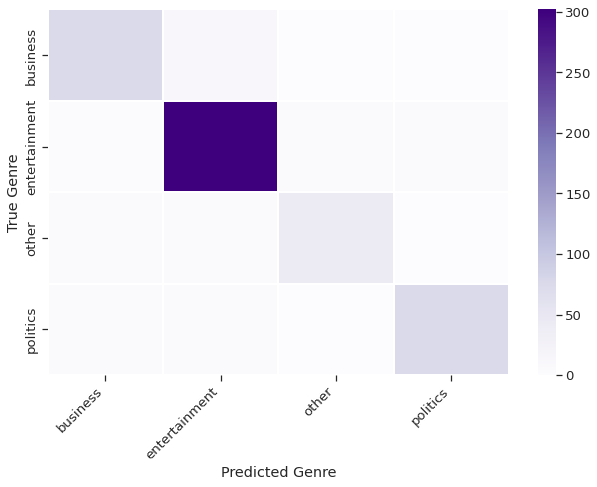

In [140]:
from collections import Counter

# Count the number of classifications for each genre pair
genre_classifications = Counter(zip(y_test, predicted_labels))

# Convert the counts to a DataFrame and pivot to wide format
df_wide = pd.DataFrame(genre_classifications, index=['Number of Classifications']).T.reset_index()
df_wide.columns = ['True Genre', 'Predicted Genre', 'Number of Classifications']
df_wide = df_wide.pivot_table(index='True Genre', columns='Predicted Genre', values='Number of Classifications', fill_value=0)

# Plot the results
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Looks good! We can see that overall, our model is assigning the correct labels for each genre. 

Now, let's remove the diagonal from the plot to highlight the misclassifications.

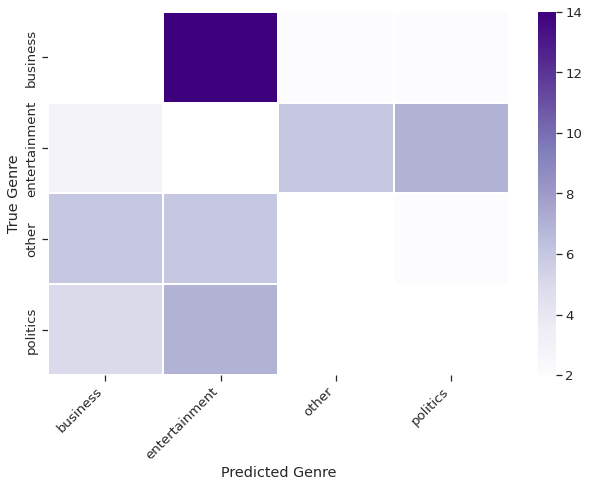

In [144]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(y_test, predicted_labels):
  if _true_label != _predicted_label: # Remove the diagonal to highlight misclassifications
    genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()